# Load data

In [1]:
API_KEY = "cvIURnhPtTHUQvmdTVJDv1mOf"

In [21]:
import pickle
from comet_ml import Experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.sparse import save_npz, load_npz



import unicodedata
import string
import nltk
import re
import spacy
import pymorphy2 
from wordcloud import WordCloud
import html
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download("stopwords")
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)

[nltk_data] Downloading package stopwords to /Users/Aska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Download stopwords list from Krinistopen GitHub
!curl -O https://raw.githubusercontent.com/Krinistopen/hse-workshop/main/rustoplist.py
from rustoplist import stopwords as ru_stopwords

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10938  100 10938    0     0  44123      0 --:--:-- --:--:-- --:--:-- 44283


In [23]:
# Create an experiment with your api key:
exp = Experiment(
    api_key=API_KEY,
    project_name="Topic model",
    workspace="warlock",
)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/warlock/topic-model/9084f5bcf7fa4080a6feda1b3dde4e0e
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/warlock/topic-model/070f8b200dd144b98046d4181708a613



In [24]:
# Load data
df = pd.read_excel('Telecom21K_anon.xlsx')
print('Dupllicates in ID?', df.ID.duplicated().any())
df = df.set_index('ID')
df.head()

Dupllicates in ID? False


,Text,Operator,Type
ID,,,
2,Являюсь клиентом Оператор1а более 15 лет.За э...,Оператор1,Мобильная связь
3,Являюсь счастливым обладателем тарифа все для ...,Оператор1,Мобильная связь
4,Являюсь пользователем услуг сотовой связи комп...,Оператор1,Мобильная связь
5,Являюсь пользователем сотового оператора Опера...,Оператор1,Мобильная связь
6,Являюсь пользователем Оператор1а лет 10. После...,Оператор1,Мобильная связь


In [25]:
# Groups of reviews
df.groupby(['Type','Operator']).count()

Text
Type            Operator       
Интернет        Оператор1  5127
                Оператор2  1607
                Оператор3  1961
Мобильная связь Оператор1  7485
                Оператор2  2727
                Оператор3  2204

In [26]:
# Convert strange unicode symbols
df.Text = df.Text.apply(lambda text: unicodedata.normalize('NFKC', str(text)))

In [27]:
# Count number of words in texts and filter texts with number of words less then 4
text_lens = df.Text.apply(lambda text: len(re.split(r'[\s,.!]',text)))
print(text_lens.sort_values(ascending=False)[-10:])
train_df = df.loc[text_lens>=4]
small_texts_df = df.loc[text_lens<4]
small_texts_df

ID
12080    2
3416     2
8754     2
8036     2
20934    2
20718    2
7425     2
11340    2
3591     1
9465     1
Name: Text, dtype: int64


,Text,Operator,Type
ID,,,
957,Спасибо!,Оператор1,Мобильная связь
1684,Регистрация контракта.,Оператор1,Мобильная связь
1687,Регион Башкирия,Оператор1,Мобильная связь
3416,Можете отключить?,Оператор1,Мобильная связь
3591,Корректировка,Оператор1,Мобильная связь
5211,Заказ контента,Оператор1,Мобильная связь
5212,Заказ контента,Оператор1,Мобильная связь
7192,29 сентября,Оператор1,Мобильная связь
7425,1 февраля,Оператор1,Мобильная связь


# Preprocessing 

In [9]:
df.Text[4]

'Являюсь пользователем услуг сотовой связи компании вымпелком. По необходимости в работе были приобретены 4 сим-карты. Какое-то время пользовались, потом в один прекрасный день, я узнал, что мои сим-карты заблокированы, но это полбеды. На всех номерах был положительный баланс, в итоге сумма более 2500 рублей на моих лицевых счетах исчезли, и естественно доступ в личный кабинет заблокирован.90347***6390941***7496046***3590940***78По номеру 90347***63, было написано заявление в мини-офисе, но ответа так и не было. По номерам 90941***74, 96046***35, 90940***78 был запрос через сайт, но после вопроса как вернуть деньги, ответов не было.'

In [10]:
# Regex pattern for punctuation, numbers that are not part of the word, 
# different links to screenshots
punct = re.compile(r'[\s{}]+'.format(re.escape(string.punctuation)))
punct_2 = re.compile(r'[،;؛¿!"\])}»›”؟¡%٪°±©®।॥…“‘„‚«‹「『\–—]')
words_with_numbers = re.compile(r'(?<!\w)\d+|\d+(?![\w\s])')
image_links = re.compile(r'https?:\/\/[0-9a-z\/\.]+\.(?:png|jpg|jpeg|gif)')
#not_uslugy = re.compile(r'(?![a-zа-я]+)_(?![a-zа-я]+)')
words_with_numbers

re.compile(r'(?<!\w)\d+|\d+(?![\w\s])', re.UNICODE)

In [11]:
words_with_numbers.sub(' ', 'Tele2 uuuu 44')

'Tele2 uuuu  '

In [12]:
# Check difference between nltk stopwords list and list from Krinistopen github
nltk_stopwords = nltk.corpus.stopwords.words("russian")
print('In NLTK list, not in github:', set(nltk_stopwords).difference(ru_stopwords))
print('In github list, not in NLTK:', set(ru_stopwords).difference(nltk_stopwords))
ru_stopwords.extend(['ним','a','http','https','www','ru','biz','com','blogs','response','responses',
                    'telecom','comments', 'comment'])

In NLTK list, not in github: {'ним'}
In github list, not in NLTK: {'бывь', 'вдали', 'мог', 'пять', 'самом', 'тех', 'говорит', 'пора', 'восемнадцатый', 'люди', 'мои', 'против', 'каждое', 'спасибо', 'те', 'отовсюду', 'близко', 'назад', 'нем', 'бывает', 'занято', 'пор', 'наше', 'нему', 'просто', 'буду', 'уметь', 'рядом', 'которая', 'будешь', 'эта', 'девятнадцатый', 'твоё', 'шестой', 'процентов', 'нам', 'само', 'мною', 'важные', 'кого', 'самим', 'четыре', 'снова', 'важный', 'недалеко', 'меля', 'которой', 'слишком', 'далеко', 'вверх', 'занята', 'наша', 'многочисленный', 'пожалуйста', 'вся', 'лет', 'иметь', 'своей', 'многочисленное', 'говорил', 'всеми', 'даром', 'этих', 'двенадцать', 'многочисленная', 'немного', 'тебе', 'заняты', 'будете', 'пока', 'которого', 'нередко', 'шесть', 'миллионов', 'отсюда', 'двадцать', 'такая', 'ею', 'особенно', 'чему', 'самому', 'свое', 'две', 'значит', 'сначала', 'вами', 'твой', 'тою', 'давно', 'мочь', 'всем', 'обычно', 'ниже', 'время', 'дел', 'мной', 'везде', '

In [42]:
# Tokenization
def tokenization(text):
    text = text.lower()
    more_html = html.unescape(text)
    
    # Eclude html tags from data
    if text != more_html:
        text = BeautifulSoup(more_html, "html").text
    
    text = image_links.sub(' ',text)
    text = punct.sub(' ',text)
    text = punct_2.sub(' ', text)
    text = words_with_numbers.sub(' ', text)
    text = re.sub(r'\s+',' ',text)
    
    return text.split()
tokens = tokenization(df.Text[18109+2])
print(tokens)

['как', 'всем', 'уже', 'стало', 'известно', 'компания', 'оператор3', 'апреля', 'года', 'закрыла', 'для', 'подключения', 'услугу', 'единый', 'интернет', 'закрытию', 'услуги', 'предшествовала', 'новость', 'на', 'сайте', 'оператор3', 'https', 'moskva', 'оператор3', 'ru', 'personal', 'novosti', 'izmenenie', 'nazvaniya', 'uslugi', 'ediniy', 'internet', 'о', 'том', 'что', 'апреля', 'будет', 'изменено', 'название', 'услуги', 'при', 'этом', 'можно', 'будет', 'добавлять', 'и', 'удалять', 'участников', 'как', 'и', 'было', 'ранее', 'я', 'в', 'тот', 'же', 'день', 'марта', 'позвонил', 'с', 'службу', 'поддержки', 'по', 'номеру', 'и', 'операторы', 'подтвердили', 'что', 'это', 'действительно', 'так', 'и', 'будет', 'по', 'неудачному', 'стечению', 'обстоятельств', 'вечером', 'апреля', 'на', 'моём', 'тарифе', 'мой', 'безлимитище', 'закончился', 'интернет', 'трафик', 'в', 'том', 'числе', 'и', 'для', 'участников', 'группы', 'единый', 'интернет', 'так', 'как', 'на', 'одном', 'из', 'номеров', 'интернет', 'по

In [43]:
# Lemmatization
morph = pymorphy2.MorphAnalyzer(lang='ru')

def lemmatization(tokens):
    final_tokens = []
    for token in tokens:
        # Get normal forms only for words with Cyrillic characters
        if re.search('[а-я]{2,}', token):
            token = morph.parse(token)[0].normal_form
            
        # Check stopwords
        if token not in ru_stopwords and len(token)>1:
            final_tokens.append(token)
    return final_tokens
final_tokens = lemmatization(tokens)
print(final_tokens)

['стать', 'известно', 'компания', 'оператор3', 'апрель', 'закрыть', 'подключение', 'услуга', 'единый', 'интернет', 'закрытие', 'услуга', 'предшествовать', 'новость', 'сайт', 'оператор3', 'moskva', 'оператор3', 'personal', 'novosti', 'izmenenie', 'nazvaniya', 'uslugi', 'ediniy', 'internet', 'апрель', 'изменить', 'название', 'услуга', 'добавлять', 'удалять', 'участник', 'ранее', 'март', 'позвонить', 'служба', 'поддержка', 'номер', 'оператор', 'подтвердить', 'неудачный', 'стечение', 'обстоятельство', 'вечером', 'апрель', 'тариф', 'безлимитища', 'закончиться', 'интернет', 'трафик', 'число', 'участник', 'группа', 'единый', 'интернет', 'номер', 'интернет', 'потребоваться', 'срочно', 'утром', 'апрель', 'прийтись', 'подключить', 'нём', 'услуга', 'супербитый', 'заработать', 'удалить', 'номер', 'группа', 'единый', 'интернет', 'итог', 'впоследствии', 'выясниться', 'прочтение', 'новость', 'сайт', 'оператор3', 'смочь', 'вернуть', 'группа', 'номер', 'обратно', 'оператор3', 'свой', 'сайт', 'новость',

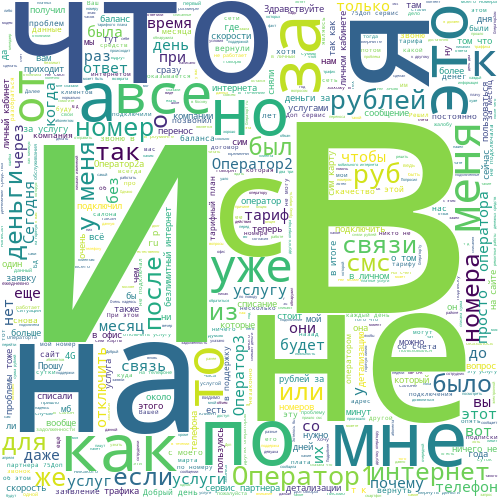

In [234]:
# Before preprocessing
long_string = ' '.join(train_df.sample(100).Text)

wordcloud = WordCloud(width = 500, height= 500, background_color="white", 
                      max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

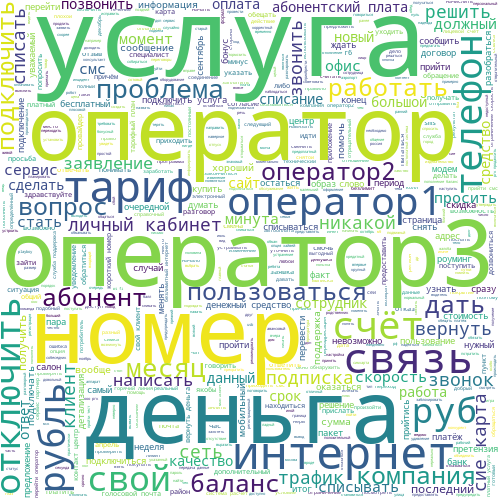

In [40]:
# After preprocessing
# Get concatenated string of preprocessed text
long_string = ''
for text in train_df.sample(100).Text:
    long_string = long_string + ' ' + ' '.join(lemma_tokenize(text))

# Generate wordcloud
wordcloud = WordCloud(width = 500, height= 500, background_color="white", 
                      max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [45]:
# Run preprocessing on full data, count occurences of words, remove too popular words
# (that are more than in 20% of documents) and words that are in only in 1 document
text_num = train_df.shape[0]
with tqdm(total=text_num) as pbar:
    def lemma_tokenize(text):
        tokens = tokenization(text)
        final_tokens = lemmatization(tokens)
        pbar.set_description('Processed')
        pbar.update(1)
        
        return final_tokens

    vectorizer = CountVectorizer(tokenizer = lemma_tokenize, lowercase=False,min_df=2, max_df=0.2)
    text_vectorized = vectorizer.fit_transform(train_df.Text)
    #print(text_vectorized)

In [536]:
# Save encoded texts and CountVectorizer
save_npz('X_countvector.npz', text_vectorized)
with open('count_vectorizer.pkl', 'wb') as fout:
    pickle.dump(vectorizer, fout)

In [48]:
#Load encoded texts and CountVectorizer
# text_vectorized = load_npz('X_countvector.npz')#.toarray()
# with open('count_vectorizer.pkl', 'rb') as f:
#     vectorizer = pickle.load(f)

In [49]:
# Let's see the most popular words and the least popular
counts_named = pd.DataFrame(text_vectorized.toarray(),columns = vectorizer.get_feature_names())
counts_sum = counts_named.sum().sort_values(ascending=False)
print(counts_sum[:10])
print(counts_sum[-10:])

оператор3    9369
оператор2    8402
руб          7756
свой         5815
компания     5437
звонок       5129
карта        5020
просить      4763
клиент       4737
средство     4632
dtype: int64
отжигать        2
отзов           2
отказатьсяот    2
отказиться      2
откликаться     2
выслуга         2
отклоняться     2
отклучить       2
отключитие      2
ёё              2
dtype: int64


In [51]:
# Use tf-idf
tfidf = TfidfTransformer()
text_tfidf = tfidf.fit_transform(text_vectorized)

In [533]:
save_npz('X_tfidf.npz', text_tfidf)

# Train model & name topics

In [121]:
# Train LDA model
def train_lda(learning_decay = 0.7):
    lda = LatentDirichletAllocation(n_components=15, n_jobs=-1, max_iter=30, verbose=1, learning_decay=learning_decay)
    lda.fit(text_tfidf)

    # Print metrics 
    print("Log Likelihood: ", lda.score(text_tfidf))
    print("Perplexity: ", lda.perplexity(text_tfidf))
    
    # Print top keywords for each topic
    words = counts_named.columns.values
    column_names = ['keyword' + str(i) for i in range(0,15)]
    results = pd.DataFrame(columns = column_names)
    
    for topic, topic_words in enumerate(lda.components_):
        topic_name = 'Topic' + str(topic)
        keyword_index = np.argsort(topic_words)[:-16:-1]
        top_values = np.round(topic_words[keyword_index],3)
        #print(dict(zip(words[keyword_index], top_values)))
        results.loc[topic_name] = words[keyword_index]
    return lda, results

In [122]:
# Learning_decay = 0.7
lda07, top_words07 = train_lda(0.7)
print(lda07.get_params())
top_words07.T

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
Log Likelihood:  -1011447.5700376201
Perplexity:  10735.63076207119
{'batch_size': 128, 'doc_topic_prior': No

,keyword0,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6,keyword7,keyword8,keyword9,keyword10,keyword11,keyword12,keyword13,keyword14
Topic0,потребитель,вправе,исполнитель,ops,gtoday,продавец,internet,закон,moscow,уплатить,фз,выполнять,ст,работа,ред
Topic1,pc,pvr,uin,alco,mccp,copinet,smsmms,просить,nng,подключать,списание,cr,gprsunlim,unlimint,здравствуйте
Topic2,temafon,ok,фотомиро,good,карманный,отклый,канал,ero,фото,fotomir,вознаграждение,лич,челябинский,ложить,далее
Topic3,балашиха,allin,вытаскивать,немочь,приморский,парнера,томский,dbm,нарый,мкрн,ёж,королева,kmr,all500,фоминск
Topic4,сервис,подписка,детализация,просить,руб,снимать,подключать,списать,здравствуйте,партнёр,средство,доп,списываться,списание,кабинет
Topic5,скорость,ограничение,модем,кб,кбит,трафик,гб,работать,сеть,хайвей,здравствуйте,упасть,сечь,сигнал,pro
Topic6,контракт,пароль,зарегистрировать,вычитать,войти,кабинет,личный,логин,приходить,ува,чё,отложной,попытка,списаный,xайвеять
Topic7,промый,пвр,инт,безлим,абоненский,дн,джи,максим,мобайл,русый,бонджорный,зеленоград,желательно,фотография,башкортостан
Topic8,xs,хайвэя,rbtsoap2,загонять,трудность,превышение,gb,айпада,голд,увеличиваться,премиальный,утечка,счётчик,безлимитка,производить
Topic9,переоформление,киви,погода,прогноз,rbtsoap3,свидетельство,network,вычитаться,fwd,валерий,несовершеннолетний,допсервис,qiwi,гл,opps


In [138]:
# Learning_decay = 0.9
lda09, top_words09 = train_lda(0.9)
top_words09.T

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
Log Likelihood:  -1013108.4989773984
Perplexity:  10900.507325834958


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14
keyword0,автооплата,оператор3,несуществующий,скорость,nng,квр,сеть,сервис,срок,pc,присутствовать,pc,подписка,лич,temafon
keyword1,задолж,оператор2,раздача,ограничение,плейбой,сра,сигнал,снимать,отложить,alco,психологический,pvr,сервис,play,фотомиро
keyword2,org,карта,переадресация,модем,услугуpc,руб,район,доп,оплата,copinet,объединить,uin,детализация,актуально,отклый
keyword3,дедушка,компания,подворовывать,кб,realunlim,задолженность,работать,партнёр,подробность,mccp,платёжный,просить,просить,локатор,зарание
keyword4,убывать,свой,украина,трафик,незнать,списание,ловить,здравствуйте,руб,gprsunlim,международный,подключать,подключать,вал,погода
keyword5,доложить,звонок,тула,кбит,рубрика,контент,дом,помочь,уважаемый,vnstunl,тест,smsmms,руб,бишь,premium
keyword6,nfc,минута,поздравление,гб,рэ,снять,дозвониться,контракт,kbp,карманный,rfz,subs,снимать,отлючить,qiwi
keyword7,запланировать,клиент,семейный,хайвей,мэджик,рассрочка,москва,зарегистрировать,платёж,ural,тверская,cdp,средство,vseinc,playboy
keyword8,aln1000,сие,сжирать,здравствуйте,кэшбэк,платёж,область,пароль,контент,gonew,оборваться,снятой,списать,nd,прогноз
keyword9,оговорить,звонить,операторский,сечь,gprswifiunlim,прийти,пропадать,подключать,прийти,vip,rf,объём,списываться,voiceunl,fotomir


In [139]:
# Learning_decay = 0.5
lda05, top_words05 = train_lda(0.5)
top_words05.T

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
Log Likelihood:  -1013928.9712416745
Perplexity:  10982.885668515499


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14
keyword0,оператор3,pc,premium,подписка,скорость,rbtsoap10,good,свидетельство,руб,сигнал,контракт,сервис,зарание,cdp,потребитель
keyword1,оператор2,alco,mobifiles,стоп,ограничение,wap,грузить,network,контент,сеть,пароль,детализация,рс,викторин,вправе
keyword2,карта,pvr,mo,отписаться,модем,клик,ok,fwd,платёж,район,зарегистрировать,подписка,mb,эрудит,исполнитель
keyword3,компания,uin,rate,активировать,трафик,helpdesk,грамотный,рубрика,оплата,ловить,ops,снимать,ставрополь,subs,промый
keyword4,свой,просить,пенза,фотомиро,кб,прогноз,утерять,аккумулятор,прийти,дом,gtoday,просить,yadi,смартфон,продавец
keyword5,звонок,mccp,альфа,нона,гб,дн,посекундный,брак,срок,работать,кабинет,подключать,sk,незаконно,закон
keyword6,клиент,copinet,брат,прийти,кбит,cb,расторгать,анлить,отложить,москва,moscow,партнёр,category,просить,безлим
keyword7,минута,smsmms,барнаул,стоимость,хайвей,qiwi,прописка,монтажник,долг,дозвониться,личный,руб,жительство,снятой,пвр
keyword8,руб,подключать,пополниться,бесплатно,здравствуйте,погода,билет,opps,подробность,область,скоростной,доп,некрасиво,участие,инт
keyword9,сие,списание,бездействовать,отправить,работать,эротический,интрнуть,смерть,уважаемый,город,internet,здравствуйте,kb,подключать,уплатить


Модель с learning_decay = 0.7 показывает наилучший результат на обеих метриках и темы довольно неплохо выделяются, поэтому будем использовать ее. Многие ключевые слова в процессе препроцессинга стали малочитабельными, к тому же многие названия подписок содержат в себе _ по которым мы их разбили на несколько слов(например pc_pc_uin_pvr, pc_alco_pc_copinet). Такие слова легко отличить, поскольку они выглядят как странные английским сокращенния. Остальные странно выглядящие слова - в основном сокращения или части сложносоставных слов. Восстановим их.

In [123]:
top_words07.T

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14
keyword0,потребитель,pc,temafon,балашиха,сервис,скорость,контракт,промый,xs,переоформление,срок,игра,викторин,новгород,оператор3
keyword1,вправе,pvr,ok,allin,подписка,ограничение,пароль,пвр,хайвэя,киви,оплата,get,эрудит,vrn,оператор2
keyword2,исполнитель,uin,фотомиро,вытаскивать,детализация,модем,зарегистрировать,инт,rbtsoap2,погода,отложить,stk,смартфон,нижний,карта
keyword3,ops,alco,good,немочь,просить,кб,вычитать,безлим,загонять,прогноз,подробность,ого,rbtsoap1,rdc,компания
keyword4,gtoday,mccp,карманный,приморский,руб,кбит,войти,абоненский,трудность,rbtsoap3,kbp,оператор2pro,ооо,рб,свой
keyword5,продавец,copinet,отклый,парнера,снимать,трафик,кабинет,дн,превышение,свидетельство,уважаемый,планшетник,отписаться,кор,звонок
keyword6,internet,smsmms,канал,томский,подключать,гб,личный,джи,gb,network,руб,yadi,участие,allinc,минута
keyword7,закон,просить,ero,dbm,списать,работать,логин,максим,айпада,вычитаться,контент,суметь,справка,зараза,клиент
keyword8,moscow,nng,фото,нарый,здравствуйте,сеть,приходить,мобайл,голд,fwd,платёж,sk,активировать,хмао,сие
keyword9,уплатить,подключать,fotomir,мкрн,партнёр,хайвей,ува,русый,увеличиваться,валерий,прийти,мэджик,москомсвязь,оператор2pro,работать


In [362]:
# Replace word contractions
replace_keywords = {'ops':'gtoday.ru/ops/', 'gtoday':'gtoday.ru/ops/',
                    'фз': 'федеральный закон', 'ст':'статья', 'ред':'редакция от',
                    'temafon' : 'temafon.ru', 'фотомиро':'фотомир', 'ok':'GOOD\'OK',
                    'good':'GOOD\'OK', 'отклый':'отключить', 'ero': 'ero.temafon.ru',
                    'ложить':'положить', 'лич':'личный кабинет', 
                    'мкрн':'микрорайон', 'ёж': 'ежемесячный', 'королева':'королев', 
                    'парнера':'партнера', 'нарый':'наро-фоминск', 'фоминск':'наро-фоминск',
                    'dbm':'dBm', 'доп':'дополнительный','сечь':'секунды', 'отложной':'отложенный',
                    'ува':'уважаемый\с уважением','xайвеять':'xайвей', 'промый':'промо',
                    'пвр':'ПВР Безлимитный Интернет','инт':'интернет','безлим':'безлимитный','дн':'день',
                    'джи':'g', 'бонджорный':'Бонджорно Мобайл Рус', 'русый':'Бонджорно Мобайл Рус',
                    'хайвэя':'хайвэй','айпада':'айпад', 'голд':'тариф голд','гл':'горячая линия',
                    'kbp':'Оператор1 KBP', 'оператор2pro': 'Оператор2pro',
                    'stk':'stk.Оператор2pro.ru/get/','get':'stk.Оператор2pro.ru/get/',
                    'yadi':'yadi.sk', 'sk':'yadi.sk','ое':'-ое', 'рб':'руб',
                    'мэджик':'Мэджик Электроникс','электроникс':'Мэджик Электроникс',
                    'хмао':'Ханты-Мансийский автономный округ','кор':'корпус',
                    'ежеднить':'ежедневно'}
top_words = top_words07.replace(replace_keywords).T
top_words

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14
keyword0,потребитель,pc,temafon.ru,балашиха,сервис,скорость,контракт,промо,xs,переоформление,срок,игра,викторин,новгород,оператор3
keyword1,вправе,pvr,GOOD'OK,allin,подписка,ограничение,пароль,ПВР Безлимитный Интернет,хайвэй,киви,оплата,stk.Оператор2pro.ru/get/,эрудит,vrn,оператор2
keyword2,исполнитель,uin,фотомир,вытаскивать,детализация,модем,зарегистрировать,интернет,rbtsoap2,погода,отложить,stk.Оператор2pro.ru/get/,смартфон,нижний,карта
keyword3,gtoday.ru/ops/,alco,GOOD'OK,немочь,просить,кб,вычитать,безлимитный,загонять,прогноз,подробность,ого,rbtsoap1,rdc,компания
keyword4,gtoday.ru/ops/,mccp,карманный,приморский,руб,кбит,войти,абоненский,трудность,rbtsoap3,Оператор1 KBP,Оператор2pro,ооо,руб,свой
keyword5,продавец,copinet,отключить,партнера,снимать,трафик,кабинет,день,превышение,свидетельство,уважаемый,планшетник,отписаться,корпус,звонок
keyword6,internet,smsmms,канал,томский,подключать,гб,личный,g,gb,network,руб,yadi.sk,участие,allinc,минута
keyword7,закон,просить,ero.temafon.ru,dBm,списать,работать,логин,максим,айпад,вычитаться,контент,суметь,справка,зараза,клиент
keyword8,moscow,nng,фото,наро-фоминск,здравствуйте,сеть,приходить,мобайл,тариф голд,fwd,платёж,yadi.sk,активировать,Ханты-Мансийский автономный округ,сие
keyword9,уплатить,подключать,fotomir,микрорайон,партнёр,хайвей,уважаемый\с уважением,Бонджорно Мобайл Рус,увеличиваться,валерий,прийти,Мэджик Электроникс,москомсвязь,Оператор2pro,работать


Теперь добабавим темы опираясь на полученные ключевые слова.

In [473]:
# Add topics
topics = ['Угрозы судебным разбирательством','Отмена подписок','Отключение Фотомира и GOOD\'OK', 
          'Плохая связь в некоторых регионах, отключение услуги', 'Лишние подписки в детализации', 
          'Низкая скорость интернета','Регистрация\вход в личный кабинет', 
          'Отключение ПВР Безлимитный Интернет, Бонджорно Мобайл Рус', 
          'Проблемы с тарифами на интернет', 'Переоформление, отключение допсервисов',
          'Отключиение услуги с отложенным платежом', 'Возврат денег за игру по ссылке',
          'Отписка от викторины', 'Отмена подписки, с указанием региона',
          'Общие вопросы к операторам'
         ]
top_words.columns = topics
top_words

,Угрозы судебным разбирательством,Отмена подписок,Отключение Фотомира и GOOD'OK,"Плохая связь в некоторых регионах, отключение услуги",Лишние подписки в детализации,Низкая скорость интернета,Регистрация\вход в личный кабинет,"Отключение ПВР Безлимитный Интернет, Бонджорно Мобайл Рус",Проблемы с тарифами на интернет,"Переоформление, отключение допсервисов",Отключиение услуги с отложенным платежом,Возврат денег за игру по ссылке,Отписка от викторины,"Отмена подписки, с указанием региона",Общие вопросы к операторам
keyword0,потребитель,pc,temafon.ru,балашиха,сервис,скорость,контракт,промо,xs,переоформление,срок,игра,викторин,новгород,оператор3
keyword1,вправе,pvr,GOOD'OK,allin,подписка,ограничение,пароль,ПВР Безлимитный Интернет,хайвэй,киви,оплата,stk.Оператор2pro.ru/get/,эрудит,vrn,оператор2
keyword2,исполнитель,uin,фотомир,вытаскивать,детализация,модем,зарегистрировать,интернет,rbtsoap2,погода,отложить,stk.Оператор2pro.ru/get/,смартфон,нижний,карта
keyword3,gtoday.ru/ops/,alco,GOOD'OK,немочь,просить,кб,вычитать,безлимитный,загонять,прогноз,подробность,ого,rbtsoap1,rdc,компания
keyword4,gtoday.ru/ops/,mccp,карманный,приморский,руб,кбит,войти,абоненский,трудность,rbtsoap3,Оператор1 KBP,Оператор2pro,ооо,руб,свой
keyword5,продавец,copinet,отключить,партнера,снимать,трафик,кабинет,день,превышение,свидетельство,уважаемый,планшетник,отписаться,корпус,звонок
keyword6,internet,smsmms,канал,томский,подключать,гб,личный,g,gb,network,руб,yadi.sk,участие,allinc,минута
keyword7,закон,просить,ero.temafon.ru,dBm,списать,работать,логин,максим,айпад,вычитаться,контент,суметь,справка,зараза,клиент
keyword8,moscow,nng,фото,наро-фоминск,здравствуйте,сеть,приходить,мобайл,тариф голд,fwd,платёж,yadi.sk,активировать,Ханты-Мансийский автономный округ,сие
keyword9,уплатить,подключать,fotomir,микрорайон,партнёр,хайвей,уважаемый\с уважением,Бонджорно Мобайл Рус,увеличиваться,валерий,прийти,Мэджик Электроникс,москомсвязь,Оператор2pro,работать


In [474]:
# Save model,topics and keywords
top_words.to_csv('top_words.csv')
with open('lda.pkl', 'wb') as fout:
    pickle.dump(lda07, fout)

In [396]:
# Load model,topics and keywords
top_words = pd.read_csv('top_words.csv',index_col=0)
with open('lda.pkl', 'rb') as f:
     lda = pickle.load(f)

In [390]:
# Find preprocessed word in dictionary
counts_named.loc[:,'ежеднить'][counts_named.loc[:,'ежеднить']>0]

753     1
1735    1
1737    1
1738    1
Name: ежеднить, dtype: int64

In [391]:
train_df.iloc[1738].Text

'Прощу Вас отключить платную дополнительную услугу партнеров за номером 50 94 по которому у меня ежеднено списывают 8 рублей за какие-то неоказанные услуги. В центре Оператор1 (г.Белорецк) не смогли помощь. В личном кабинете данная услуга(?)( подписка?) не значится.'

In [376]:
# Find word in all texts
for i, t in enumerate(df.Text):
    if 'stk.оператор2pro' in t.lower():
        print(i,t)

13125 Сегодня 25.06.2015 в 17.21 пришло на телефон сообщение с предложением покупки ""Парк юркского периода"", при нажатии правой кнопки (сброс) поблагодарили за покупку и прислали сообщение с номера 5016 со следующим текстом  http://stk.Оператор2pro.ru/get/Hewtjioc ""Парк Юрск пер"". Это безобразие!
13968 Мне пришло сообщения, я хотела выйти и удалить сообщение, но вместо этого у меня прошла оплата. И мне сруза же прислали ссылку на игру http://stk.Оператор2pro.ru/get/VRrfkqHI@WorldFootball2014@  Прошу помогите вернуть деньги. Я не заказывала эту игру.
14237 Здравствуйте. Сегодня нам мой номер пришло рекламное СМС с предложением купить некую игру с номера 5016.Когда хотела прочитать сообщение, я нажал на левую кнопку на телефоне - там вместо прочитать оказалась кнопка ОК. На автомате нажал, не успев среагировать, меня поблагодарили за покупку и прислали по СМС ссылку http://stk.Оператор2pro.ru/get/wetmshyq ""Черепашки ниндзя""на игру с номера 5016. Полученную услугу я не заказывал, хо

# Predict topic 

In [477]:
# Predict categories
predicted = lda.transform(text_tfidf[120:130])
pd.DataFrame(predicted, columns = top_words.columns).T

,0,1,2,3,4,5,6,7,8,9
Угрозы судебным разбирательством,0.012994,0.006746,0.006073,0.008694,0.015228,0.041626,0.014130,0.041168,0.009750,0.013063
Отмена подписок,0.012994,0.006746,0.006073,0.008694,0.015228,0.009987,0.014130,0.005926,0.009750,0.013063
Отключение Фотомира и GOOD'OK,0.012994,0.006746,0.006073,0.008694,0.015228,0.009987,0.014130,0.005926,0.009750,0.013063
"Плохая связь в некоторых регионах, отключение услуги",0.012994,0.006746,0.006073,0.008694,0.015228,0.009987,0.014130,0.005926,0.009750,0.013063
Лишние подписки в детализации,0.157025,0.029011,0.006073,0.008695,0.086393,0.010007,0.014130,0.069601,0.009750,0.013063
Низкая скорость интернета,0.012994,0.006746,0.006073,0.008695,0.015228,0.009990,0.014130,0.005926,0.034424,0.013063
Регистрация\вход в личный кабинет,0.012994,0.018936,0.006073,0.033045,0.015228,0.009987,0.014130,0.005926,0.009750,0.013063
"Отключение ПВР Безлимитный Интернет, Бонджорно Мобайл Рус",0.012994,0.006746,0.006073,0.008694,0.015228,0.009988,0.014130,0.005926,0.009750,0.013063
Проблемы с тарифами на интернет,0.012994,0.006746,0.006073,0.008694,0.015228,0.009997,0.014130,0.023477,0.009751,0.013063
"Переоформление, отключение допсервисов",0.212722,0.006746,0.006073,0.008694,0.015228,0.009990,0.014130,0.005926,0.009751,0.013063


In [478]:
# Predict categories on full data
predicted = lda.transform(text_tfidf)
categories = top_words.columns.values[np.argmax(predicted,axis=1)]
pd.value_counts(categories)

Общие вопросы к операторам                                   12749
Лишние подписки в детализации                                 5792
Низкая скорость интернета                                     1514
Отключиение услуги с отложенным платежом                       362
Отмена подписок                                                311
Отписка от викторины                                           131
Регистрация\вход в личный кабинет                               47
Угрозы судебным разбирательством                                46
Отключение Фотомира и GOOD'OK                                   28
Переоформление, отключение допсервисов                          24
Отключение ПВР Безлимитный Интернет, Бонджорно Мобайл Рус       20
Плохая связь в некоторых регионах, отключение услуги            19
Возврат денег за игру по ссылке                                 17
Проблемы с тарифами на интернет                                 13
Отмена подписки, с указанием региона                          

Довольно мало тектстов вне трех основных тем - общей, лишнних подписок и проблем со скоростью интернета. В целом выгялядит довольно логично, к тому же по самим видам подписок довольно сложно разделять тексты - большая часть из них выглядит как pc_pc_ugi_pbg или как-то еще нечитаемо. С другой стороны общие вопросы вероятно должны разделяться на большее число групп. Поскольку в обычных координатах не очень хорошо видно темы из малого числа элементов, перейдем в логарифмическую шкалу.

In [482]:
# Add topics to original table
df.loc[:,'topic'] = 'Прочее'
df.loc[text_lens>=4,'topic'] = categories
df.to_csv('Telecom_with_topics.csv')
df.head()

Text(0.5, 1.0, 'Categories sizes(log-scaled)')

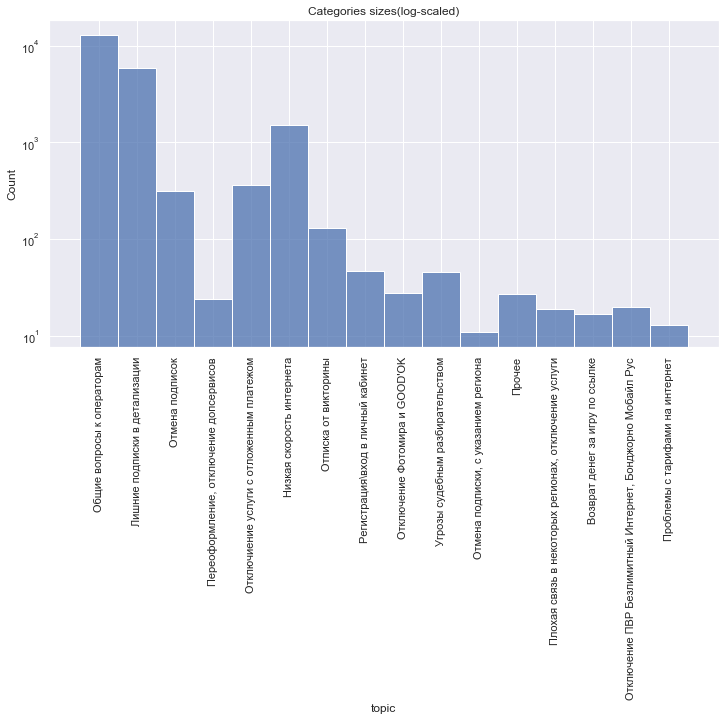

In [515]:
# Plot distribution of categories(log-scaled)
fig,ax = plt.subplots()
sns.histplot(x='topic', data=df,bins=15,ax=ax)
plt.xticks(rotation=90)
ax.set_yscale('log')
ax.set_title('Categories sizes(log-scaled)')

In [537]:
# Get scores for topics for all texts
predicted = lda.transform(text_tfidf)
top_scores = np.max(predicted,axis=1)

In [538]:
# Add scores for topics to data table
text_lens = df.Text.apply(lambda text: len(re.split(r'[\s,.!]',text)))
df.loc[:,'top_score'] = np.NaN
df.loc[text_lens>=4,'top_score'] = top_scores

In [539]:
df.to_csv('Telecom_with_topics.csv')